In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import natsort

%matplotlib inline
plt.style.use('seaborn')

df = pd.read_csv('./stack-overflow-developer-survey-2021/survey_results_public.csv')
df_questions = pd.read_csv('./stack-overflow-developer-survey-2021/survey_results_schema.csv')


def countVisitFreq(index):
    counts = (df.loc[:, [index,'SOVisitFreq']]
                            .groupby([index,'SOVisitFreq'])
                            .value_counts()
                            .reset_index())
    freqSortList = ['Less than once per month or monthly',
                     'A few times per month or weekly',
                     'A few times per week',
                     'Daily or almost daily',
                     'Multiple times per day']
    return counts.pivot(index=index, columns='SOVisitFreq', values=0)[freqSortList]

In [2]:
df.head()

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN


## Preprocessing

In [35]:
len(df.dropna(how='any'))

0

Stack Overflow did not force participants to answer every questions. In fact, no respondents answers every single questions in the survey. Therefore, we need to be forgiving when treating NA values in this survey, or we could be left with no respondents at all.

In [3]:
len(df) - len(df.dropna(how='all'))

0

On the other hand, you could not find respondents that choose not to answer every single questions either.


## Stack Overflow Visit Frequency

let's find who are Stack Overflow daily visitors! by demographics, skills? education? favourite techs if justified?

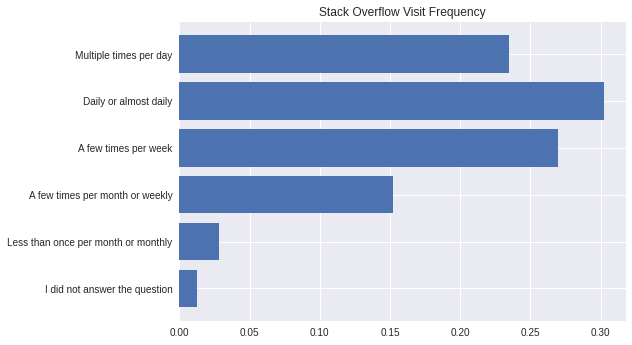

In [22]:
visitors = df['SOVisitFreq'].fillna("I did not answer the question").value_counts(normalize=True, dropna=False)[['Multiple times per day', 'Daily or almost daily', 'A few times per week',
        'A few times per month or weekly', 'Less than once per month or monthly', "I did not answer the question"]]
plt.barh(visitors.index, visitors.values)
plt.title('Stack Overflow Visit Frequency')
plt.gca().invert_yaxis()
plt.show()

Majority of respondents visit stack overflow very often. 30.3% of respondents visit Stack Overflow daily, 23.4% even visit Stack Overflow multiple times a day. Combined, this means that 53.7% of total respondents says that they visit Stack Overflow in a daily basis or more often. The rest of the respondents report that they visit Stack Overflow less often. About 26.94% visit the site a few times per week, 15.2% visit the site a few times per month and a further 0.028% visit the site less than once per month.

Since Stack Overflow don't force respondents to answer questions, there would be a portion of respondents that choose not to answer some questions. About 1.2%. respondents choose not to answer this question.

Next, we will divide visit frequency into daily visitors and non daily visitors. We will define daily visitors as those respondents who reports that they visit the site daily or multiple times per day. Otherwise, they are not a daily visitor. Daily visitors will be labeled "Daily". Otherwise, they will be labeled "Not Daily".

In [10]:
df.dropna(subset='SOVisitFreq')

df['SOVisitFreq_Daily'] = df['SOVisitFreq'].replace(['Multiple times per day', 'Daily or almost daily',
       'A few times per week', 'A few times per month or weekly',
       'Less than once per month or monthly'], ['Daily','Daily','Not Daily','Not Daily','Not Daily',])

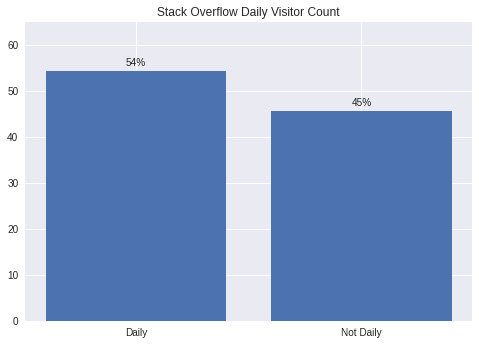

In [33]:
dailyVisitors  = df['SOVisitFreq_Daily'].value_counts(normalize=True) * 100

f, ax = plt.subplots()
rect = ax.bar(dailyVisitors.index, dailyVisitors.values)
ax.bar_label(rect, padding=3, fmt='%d%%') 
ax.set_title('Stack Overflow Daily Visitor Count')
ax.set_ylim(0,65)
plt.show()

Here, we have slightly more daily Stack Overflow visitors than non daily visitors. About 54% of respondents visit Stack Overflow on a daily basis while 45% of respondents visit Stack Overflow not so often.

## Demographics Differences

In [6]:
#select top 10 countries with largest respondents
top10Country = df['Country'].value_counts().sort_values(ascending=False)[:10].index.array
country_counts = (df.loc[df['Country'].isin(top10Country), ['Country','SOVisitFreq']]
                        .groupby(['Country','SOVisitFreq'])
                        .value_counts()
                        .reset_index())
freqSortList = ['Less than once per month or monthly',
                 'A few times per month or weekly',
                 'A few times per week',
                 'Daily or almost daily',
                 'Multiple times per day']
countryCombine = country_counts.pivot(index='Country', columns='SOVisitFreq', values=0)[freqSortList]
countryCombine

SOVisitFreq,Less than once per month or monthly,A few times per month or weekly,A few times per week,Daily or almost daily,Multiple times per day
Country,,,,,
Brazil,74,372,589,695,510
Canada,97,575,918,809,578
France,70,369,720,857,664
Germany,141,902,1683,1659,1222
India,197,1081,2210,3577,3256
Italy,25,174,388,601,468
Netherlands,51,286,528,550,355
Poland,44,308,556,541,348
United Kingdom of Great Britain and Northern Ireland,163,810,1383,1213,885


yep pretty much doesn't deviate the rules. visitors usually visit the site a few times per week or daily.

In [7]:
yearCodeCounts = (df.loc[:, ['YearsCode','SOVisitFreq']]
                        .groupby(['YearsCode','SOVisitFreq'])
                        .value_counts()
                        .reset_index())
freqSortList = ['Less than once per month or monthly',
                 'A few times per month or weekly',
                 'A few times per week',
                 'Daily or almost daily',
                 'Multiple times per day']
yearsCodeCombined = yearCodeCounts.pivot(index='YearsCode', columns='SOVisitFreq', values=0)[freqSortList]
yearsCodeCombined

SOVisitFreq,Less than once per month or monthly,A few times per month or weekly,A few times per week,Daily or almost daily,Multiple times per day
YearsCode,,,,,
1,89,309,439,445,320
10,155,837,1570,1897,1577
11,52,302,641,732,610
12,59,474,847,1033,764
13,48,270,542,648,503
14,39,290,515,523,440
15,103,586,1022,1095,799
16,44,240,410,469,320
17,36,224,375,396,293


In [8]:
test_indexer = ['Less than 1 year'] + [str(i) for i in range(1,51)] + ['More than 50 years']
yearsCodeCombined = yearsCodeCombined.T
#df years code and visit frequency 
test = (yearsCodeCombined / yearsCodeCombined.sum())
test = test.T.loc[test_indexer,:]

Text(0.5, 1.0, 'Experience vs Percentage of Daily Visits')

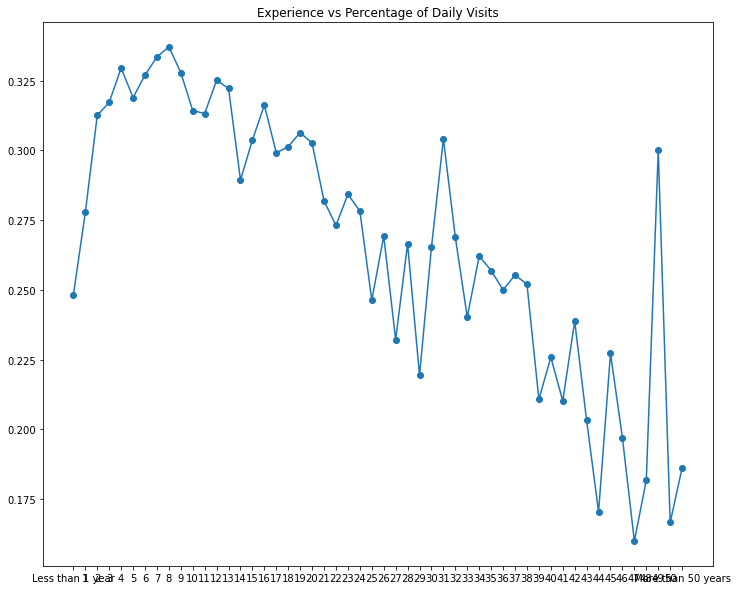

In [9]:
data = test.iloc[:,3]
f, ax = plt.subplots(figsize=(12,10))
ax.scatter(data.index, data.array)
ax.plot(data.index, data.array)
ax.set_title('Experience vs Percentage of Daily Visits')

As people enter the world of programming, their visit to the Stack Overflow site initially increases. after reaching the peak in 7th year of programming, their use sharply declines. Note that Stack Overflow was launched in 2008. Before 2008, there was no Stack Overflow, so people might used to conceive their own way when they stuck on a problem.

Text(0.5, 1.0, 'Experience vs Percentage of Weekly Visits')

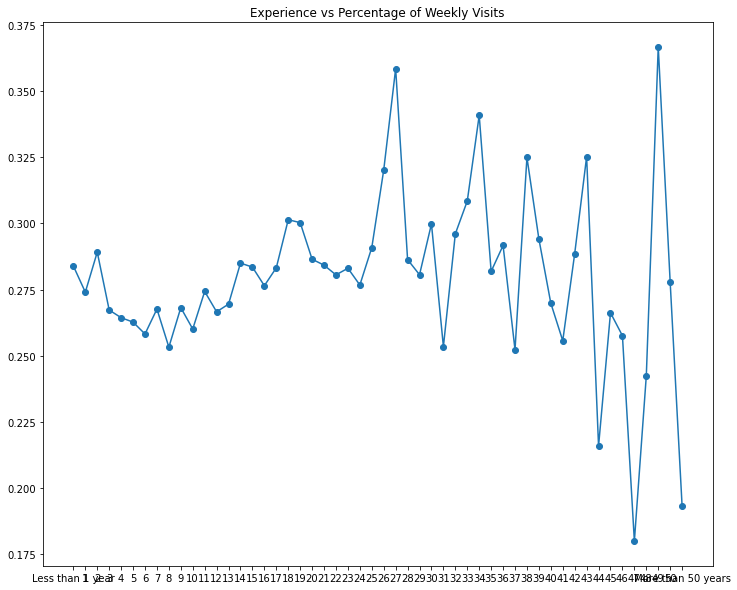

In [10]:
data = test.iloc[:,2]
f, ax = plt.subplots(figsize=(12,10))
ax.scatter(data.index, data.array)
ax.plot(data.index, data.array)
ax.set_title('Experience vs Percentage of Weekly Visits')

the data is fairly heteroskedastic. if you try, you may discern a zigzag pattern.. an initial decline followed by sharp incline then followed by a heteroskedastic decline. but to me this looks mainly heteroskedastic.

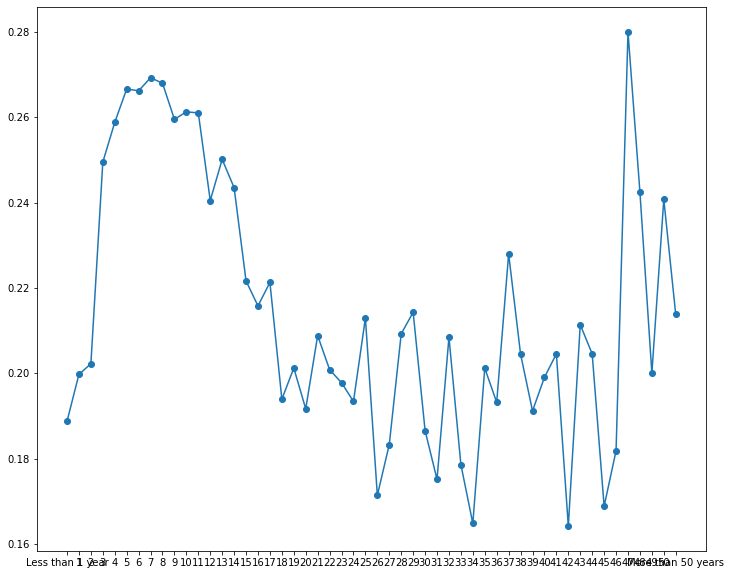

In [11]:
data = test.iloc[:,4]
f, ax = plt.subplots(figsize=(12,10))
ax.scatter(data.index, data.array)
ax.plot(data.index, data.array)
# ax.set_title('Experience vs Percentage of Weekly Visits')

this data is also fairly heteroskedastic. we can still see that people having low to medium level of experience (under 7 years) usually increases their visit to stack overflow, with a sharp decline afterwards, and an inconsistent pattern follows after their experience reaches 15 years.

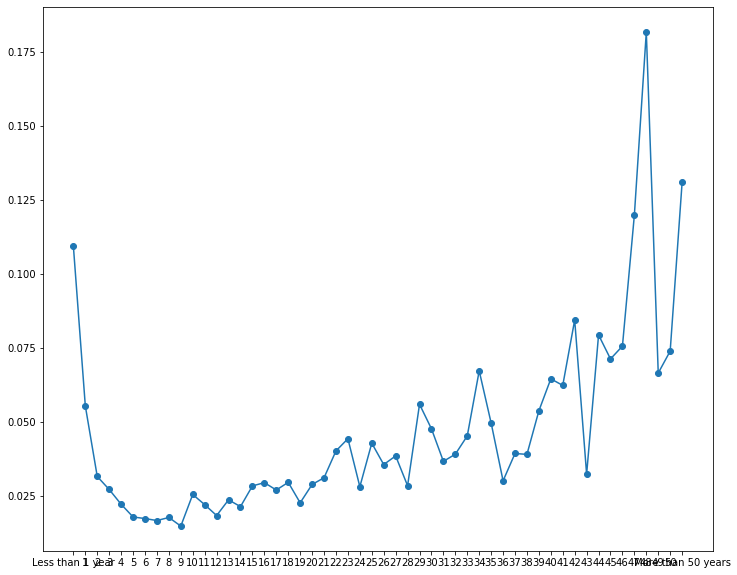

In [12]:
data = test.iloc[:,0]
f, ax = plt.subplots(figsize=(12,10))
ax.scatter(data.index, data.array)
ax.plot(data.index, data.array)
# ax.set_title('Experience vs Percentage of Weekly Visits')

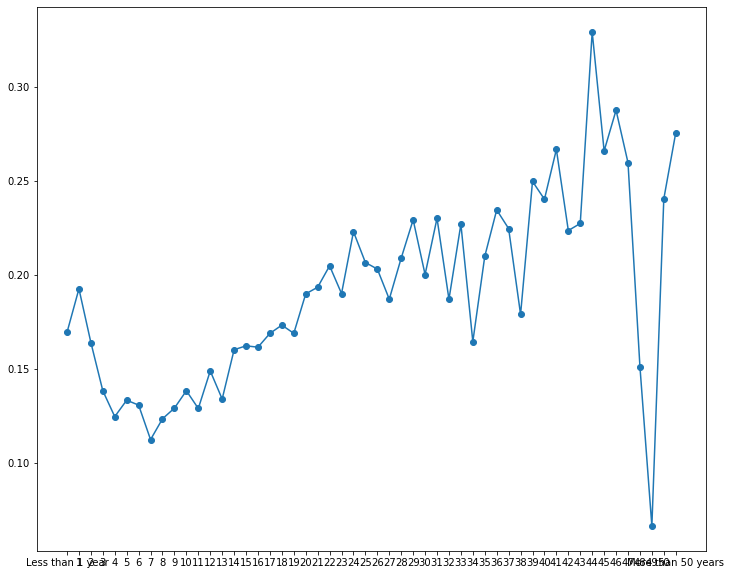

In [13]:
data = test.iloc[:,1]
f, ax = plt.subplots(figsize=(12,10))
ax.scatter(data.index, data.array)
ax.plot(data.index, data.array)
# ax.set_title('Experience vs Percentage of Weekly Visits')

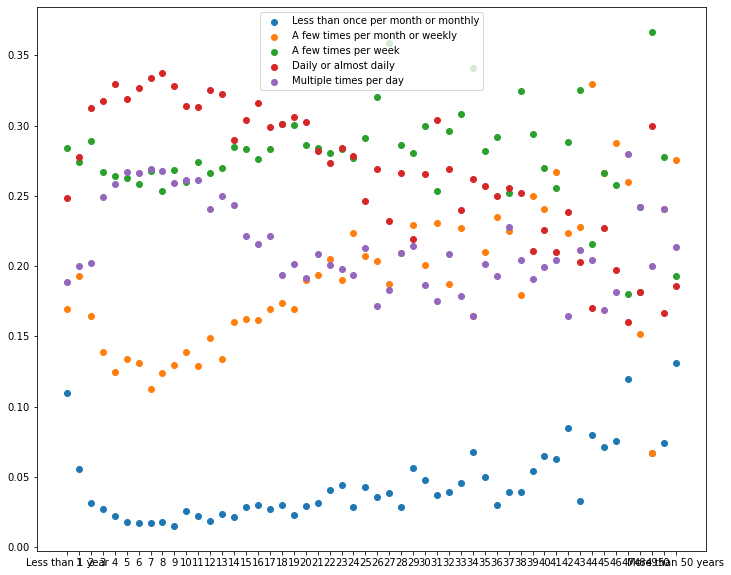

In [15]:
f, ax = plt.subplots(figsize=(12,10))
for i in test.columns:
    data = test.loc[:,i]
    ax.scatter(data.index, data.array, label=i)
#     ax.plot(data.index, data.array)
ax.legend()

when we look at people with lowest programming experience (under 7 years) initially, daily and multiple times per day increases as people gain experience in this group, while a few times per week and a few times per month declines. This means more people visit Stack Overflow more often as they gain experience. However, this situation will turn as we look at programmers who have more than 7 years of experience. for this group, their number of daily visitors and multiple times per day declines as the number of programmers who visit Stack Overflow a few times per week and a few times per month increases. This means that after 7 years of experience, they will visit Stack Overflow less often. Maybe a few times per week or per month, rather than daily or multiple times per day.

it was unclear at this point why the graph oscillates for people that have more than 24 years of coding experience. One thing that can be checked is sample size. If the number is rather slim, there is more proof that the instability may come from the sample size, particularly if the number of sample is less than 300 (source).

Another thing that can be pointed out is that stack overflow was launched in 2008, about 14 years ago, so some kind of assumption that younger programmers are more familiar with Stack Overflow than older programmers. but there are two kinds of objection about this thinking: these are programmers, aren't they familiar with tools like Stack Overflow? if so, is there any other tool they use when these older programmers are stuck with a problem, which they use more often, which they are more familiar with, so that they trust this method more than simply opening a browser to visit a site? while the former question require more data, fortunately the latter question can be answered with the survey data.

## Does the instability goes away?
To know exactly how much respondents is enough to represent an experience group, but we are setting 300 as a limit just to be safe. Let's remove experiences whose respondents are less than 300.

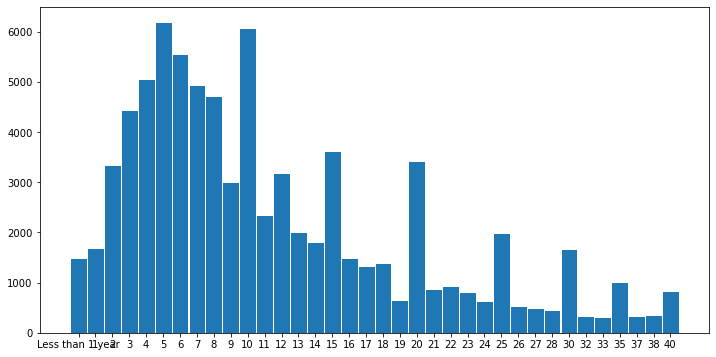

In [20]:
yearscode = df['YearsCode'].value_counts().loc[test_indexer]
yearsCodeLarge = yearscode[yearscode >= 300]
plt.figure(figsize=(12,6))
plt.bar(yearsCodeLarge.index, yearsCodeLarge.values, width=1, edgecolor='white')
plt.show()

<StemContainer object of 3 artists>

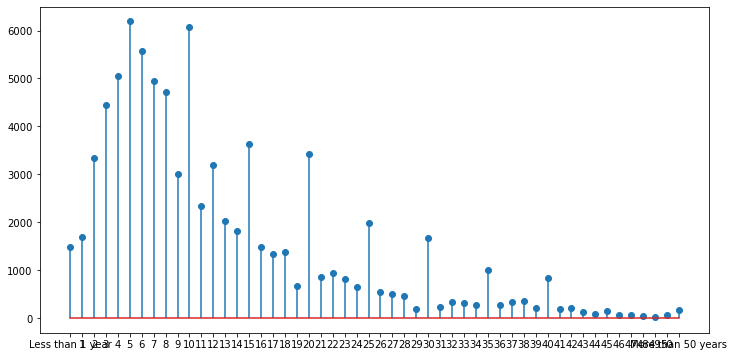

In [19]:
test_indexer = ['Less than 1 year'] + [str(i) for i in range(1,51)] + ['More than 50 years']
yearscode = df['YearsCode'].value_counts().loc[test_indexer]
plt.figure(figsize=(12,6))
plt.stem(yearscode.index, yearscode.values)

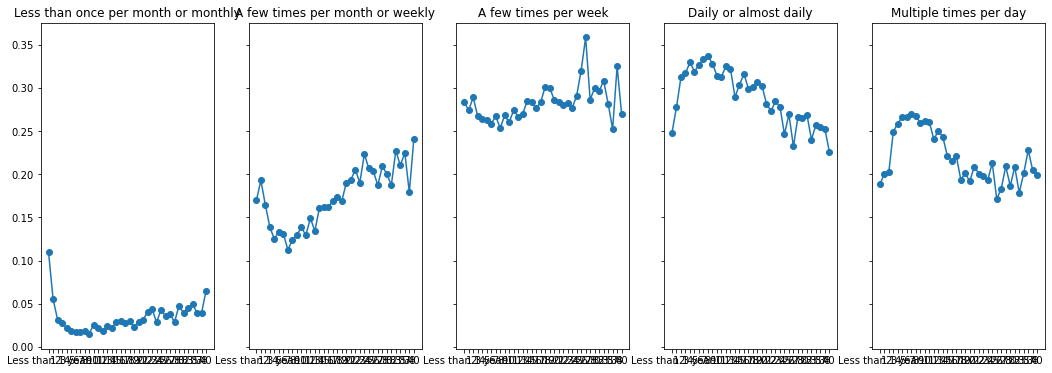

In [50]:
experiencevFrequency = test.loc[yearscode > 300]
f, ax = plt.subplot_mosaic([[0,1,2,3,4]], sharey=True, figsize=(18,6))

for n in range(5):
    ax[n].scatter(experiencevFrequency.index, experiencevFrequency.iloc[:,n])
    ax[n].plot(experiencevFrequency.index, experiencevFrequency.iloc[:,n])
    ax[n].set_title(experiencevFrequency.iloc[:,n].name)

We can conclude that the largest majority of Stack Overflow visitors tend to visit the site daily or a few times per week. The number of respondents who visit the site daily or multiple times per day peaks the most around 4-11 years of experience. after that, the number of frequent visitors tend to decline as people visit Stack Overflow less. This means as people have dozens of years experience, they visit the site less often. Maybe a few times per week or daily, but no longer multiple times per day. However, even with this decline, the majority still tend to visit the site daily or a few times per week across all experience groups.

## Years of Professional Coding

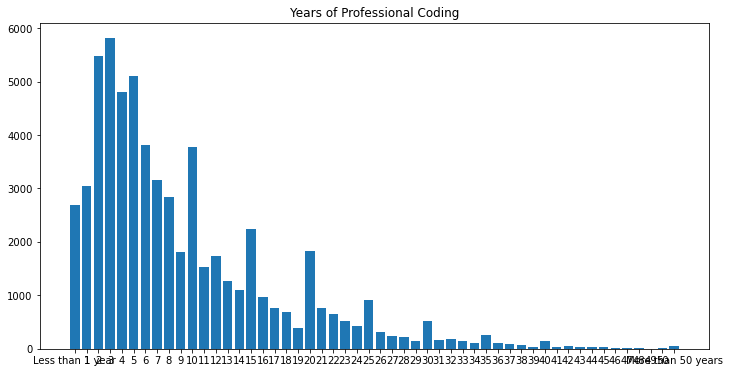

In [42]:
test_indexer = ['Less than 1 year'] + [str(i) for i in range(1,51)] + ['More than 50 years']
yearsCodePro = df['YearsCodePro'].value_counts().loc[test_indexer]
plt.figure(figsize=(12,6))
plt.bar(yearsCodePro.index, yearsCodePro.array)
plt.title('Years of Professional Coding')
plt.show()

note that 5 folds still get the highest count, repeating the previous pattern. Also professional coding experience is much more skewed.

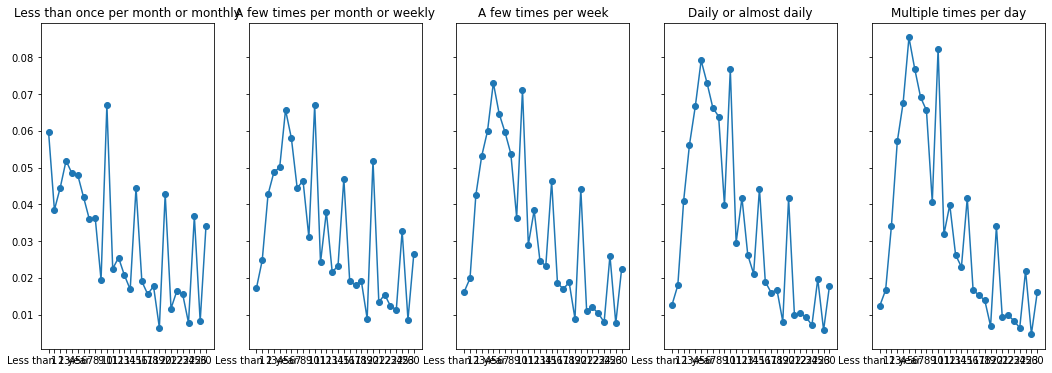

In [51]:
yearCodeProCounts = (df.loc[:, ['YearsCodePro','SOVisitFreq']]
                        .groupby(['YearsCodePro','SOVisitFreq'])
                        .value_counts()
                        .reset_index())

yearsCodeProCombined = yearCodeProCounts.pivot(index='YearsCodePro', columns='SOVisitFreq', values=0)
yearsCodeProCombined

freqSortList = ['Less than once per month or monthly',
                 'A few times per month or weekly',
                 'A few times per week',
                 'Daily or almost daily',
                 'Multiple times per day']
test_indexer = ['Less than 1 year'] + [str(i) for i in range(1,51)] + ['More than 50 years']

#df years code and visit frequency 
yearsCodeProNorm = (yearsCodeCombined.T / yearsCodeCombined.T.sum())
#retranspose, then sort the index and column
yearsCodeProNorm = yearsCodeProNorm.loc[test_indexer,freqSortList]

yearsCodeProNormLarge = yearsCodeProNorm[yearsCodePro >= 300]

f, ax = plt.subplot_mosaic([[0,1,2,3,4]], sharey=True, figsize=(18,6))

for n in range(5):
    ax[n].scatter(yearsCodeProNormLarge.index, yearsCodeProNormLarge.iloc[:,n])
    ax[n].plot(yearsCodeProNormLarge.index, yearsCodeProNormLarge.iloc[:,n])
    ax[n].set_title(yearsCodeProNormLarge.iloc[:,n].name)

weird. very similar between all of them.

## What to do when stuck?

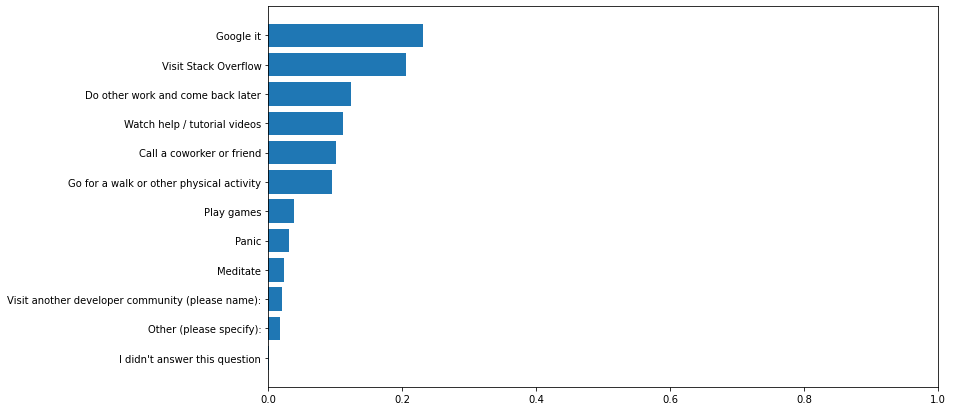

In [16]:
generalStuck = (df['NEWStuck']
         .fillna("I didn't answer this question")
         .str.split(';', expand=True)
         .stack()
         .value_counts(normalize=True))

f, ax = plt.subplots(figsize=(12,7))
ax.barh(generalStuck.index, generalStuck.array)
ax.set_xlim(0,1)
ax.invert_yaxis()
plt.show()

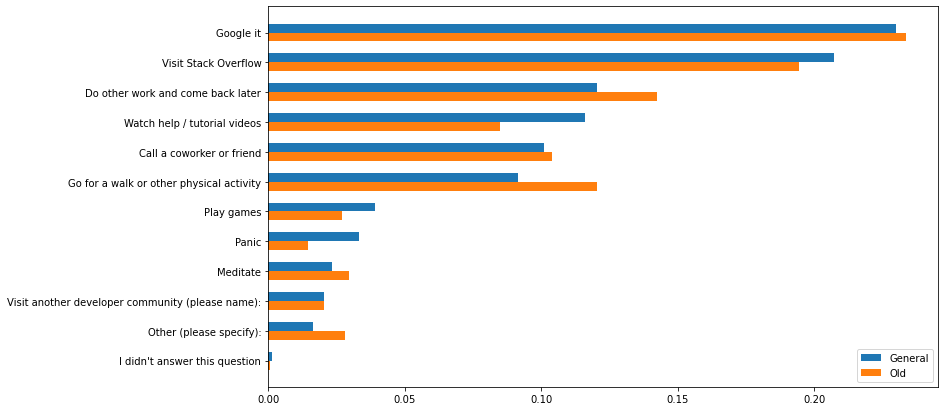

In [17]:
oldAge = [str(i) for i in range(24,51)] + ['More than 50 years']
oldStuck = (df.loc[df['YearsCode'].isin(oldAge), 'NEWStuck'].fillna("I didn't answer this question")
            .str.split(';', expand=True)
            .stack()
            .value_counts(normalize=True))

generalStuck = (df.loc[~df['YearsCode'].isin(oldAge), 'NEWStuck']
                .fillna("I didn't answer this question")
                .str.split(';', expand=True)
                .stack()
                .value_counts(normalize=True))

stuck = pd.concat([generalStuck.rename('General'), oldStuck.rename('Old')], axis = 1)

pos, height = np.arange(len(stuck)), 0.3

f, ax = plt.subplots(figsize=(12,7))
ax.barh(pos-height/2, stuck['General'], height=height, label=stuck['General'].name)
ax.barh(pos+height/2, stuck['Old'], height=height, label=stuck['Old'].name)
ax.set_yticks(pos, stuck.index)
ax.invert_yaxis()
ax.legend(loc='lower right')
plt.show()

do we compare them to the general generation or to the YOUNGER generation?

might be interesting to divide them to three parts: those whose visit freq goes up, those who goes down, and those who are all over the place???

but sure enough, old generations with experience are less likely to panic than the general pop. although panic still do exist.

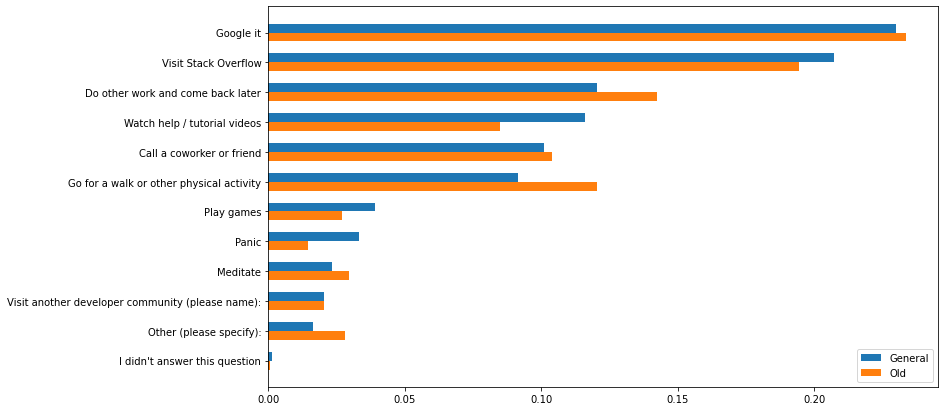

In [18]:
oldAge = [str(i) for i in range(24,51)] + ['More than 50 years']
oldStuck = (df.loc[df['YearsCode'].isin(oldAge), 'NEWStuck'].fillna("I didn't answer this question")
            .str.split(';', expand=True)
            .stack()
            .value_counts(normalize=True))

generalStuck = (df.loc[~df['YearsCode'].isin(oldAge), 'NEWStuck']
                .fillna("I didn't answer this question")
                .str.split(';', expand=True)
                .stack()
                .value_counts(normalize=True))

stuck = pd.concat([generalStuck.rename('General'), oldStuck.rename('Old')], axis = 1)

pos, height = np.arange(len(stuck)), 0.3

f, ax = plt.subplots(figsize=(12,7))
ax.barh(pos-height/2, stuck['General'], height=height, label=stuck['General'].name)
ax.barh(pos+height/2, stuck['Old'], height=height, label=stuck['Old'].name)
ax.set_yticks(pos, stuck.index)
ax.invert_yaxis()
ax.legend(loc='lower right')
plt.show()

Note that there is a sharp increase between folds of 5: the size of respondents with 5, 10, 15, 20, 25, 30, 35 and 40 is higher than its surrounding experience levels. The author believes that this is the effect of rounding. rather than giving exact age of experience, the respondents tend to give ballparks.

## Another Factor

### Developer type (Job Titles)

We will try to group visit frequency by respondents' job titles. The aim of this attempt is to see if there is a difference in daily visit frequency between job titles. In the Stack Overflow survey data, the question that inquire respondents' job title is labeled "DevType".

In both questions, there are a number of respondents that choose not to answer the questions. We need to deal with this NA values. We will ignore the NA values. This is because we cannot map NA values to any real values, therefore the NA values don't reveal valuable information. Therefore, this means leaving the columns as is since many pandas operations automatically ignore NA values.

On the other hand, aside from removing them, one may be able to impute/fill or predict the real values behind the NA values. For a further discussion about choosing methods for imputing NA values, see Buuren (2018): Flexible Imputation of Missing Data https://stefvanbuuren.name/fimd/

In [42]:
DevTypevFreq = df['DevType'].str.get_dummies(';').groupby(df['SOVisitFreq_Daily']).sum().T
DevTypevFreq['Difference'] = DevTypevFreq['Daily'] - DevTypevFreq['Not Daily']
DevTypevFreq.sort_values('Difference')

SOVisitFreq_Daily,Daily,Not Daily,Difference
Other (please specify):,1538,2007,-469
Engineering manager,1743,2067,-324
"Senior Executive (C-Suite, VP, etc.)",931,1172,-241
Marketing or sales professional,285,353,-68
"Engineer, site reliability",1220,1228,-8
Academic researcher,1467,1432,35
Scientist,1027,988,39
Educator,1207,1162,45
"Developer, game or graphics",1084,1028,56
Product manager,1567,1507,60


Across most of the job titles, there are more people who visit Stack Overflow daily than not daily. An exception could be placed on engineering managers, senior executives, marketing professionals and site reliability engineers. Most of these job titles are not involved in day-to-day engineering, so it is not unexpected. Furthermore, the number of daily v non daily visitors of site reliabilily engineers only differs slightly.

In [43]:
LearnCodevFreq = df['LearnCode'].str.get_dummies(';').groupby(df['SOVisitFreq_Daily']).sum().T
LearnCodevFreq['Difference'] = LearnCodevFreq['Daily'] - LearnCodevFreq['Not Daily']
LearnCodevFreq.sort_values('Difference')

SOVisitFreq_Daily,Daily,Not Daily,Difference
Other (please specify):,3658,3266,392
Books / Physical media,21952,20800,1152
Coding Bootcamp,4926,3570,1356
Friend or family member,8265,6897,1368
Colleague,8311,5914,2397
Online Forum,14996,11233,3763
School,24174,20288,3886
Online Courses or Certification,19378,14133,5245
"Other online resources (ex: videos, blogs, etc)",27405,21987,5418


Daily visitors are more numerous than non daily visitors across learning platforms.

<BarContainer object of 8 artists>

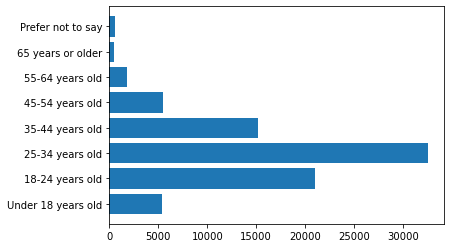

In [20]:
age = df['Age'].value_counts().loc[['Under 18 years old',
                              '18-24 years old',
                              '25-34 years old',
                              '35-44 years old',
                              '45-54 years old', 
                              '55-64 years old', 
                              '65 years or older',
                              'Prefer not to say']]

plt.barh(age.index, age.array)

<BarContainer object of 9 artists>

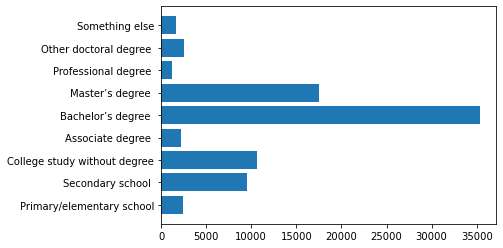

In [34]:
sorter = ['Primary/elementary school',
          'Secondary school ', 'College study without degree', 
          'Associate degree ', 'Bachelor’s degree ', 'Master’s degree ',
          'Professional degree ', 'Other doctoral degree ',
          'Something else' ]

edu = (df['EdLevel']
       .str.replace(r'\(.*\)', '', regex=True)
       .replace('Some college/university study without earning a degree', 'College study without degree')
       .value_counts()
       .loc[sorter])

plt.barh(edu.index, edu.array)

<BarContainer object of 9 artists>

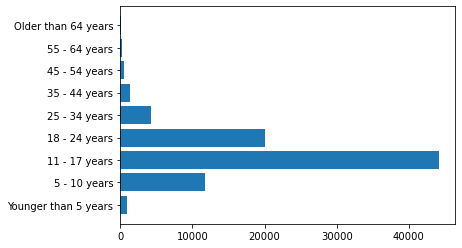

In [71]:
age1stCode = df['Age1stCode'].value_counts().sort_index(key=natsort.natsort_keygen())
sorter = ['Younger than 5 years'] + [i for i in age1stCode.index[0:-1]]
age1stCode = age1stCode[sorter]

plt.barh(age1stCode.index, age1stCode.array)
#might lack representativeness from other age groups, therefore limiting comparisons.

In [72]:
df['ConvertedCompYearly']

0         62268.0
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
83434    160500.0
83435      3960.0
83436     90000.0
83437    816816.0
83438     21168.0
Name: ConvertedCompYearly, Length: 83439, dtype: float64

## Predicting daily users with logistic regression
First we group daily visitors and non daily visitors using .replace(). We didn't use one-how encoding because daily users in this dataset comprises of two groups: those who visit daily and those who visit multiple times per day. We replace those values with 1, then the rest with 0.

In [91]:
#dependent variable to predict daily visitors
dv = (df['SOVisitFreq']
      .replace(['Multiple times per day', 'Daily or almost daily',
       'A few times per week', 'A few times per month or weekly', np.NaN,
       'Less than once per month or monthly'], ['Daily', 'Daily', 0, 0, 0, 0])
      .value_counts())
dv

Daily    44842
0        38597
Name: SOVisitFreq, dtype: int64

Then, we check whether all the replacement has been done correctly.

In [87]:
df['SOVisitFreq'].isin(['Daily or almost daily', 'Multiple times per day']).sum()

44842

Things are looking good.